In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astroquery.vizier import Vizier
import subprocess
import os

In [2]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('source-extractor', 'sex'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

source-extractor is installed properly as sex. OK
psfex is installed properly as psfex. OK
2 out of 2 external dependencies installed properly.

You are ready to continue.


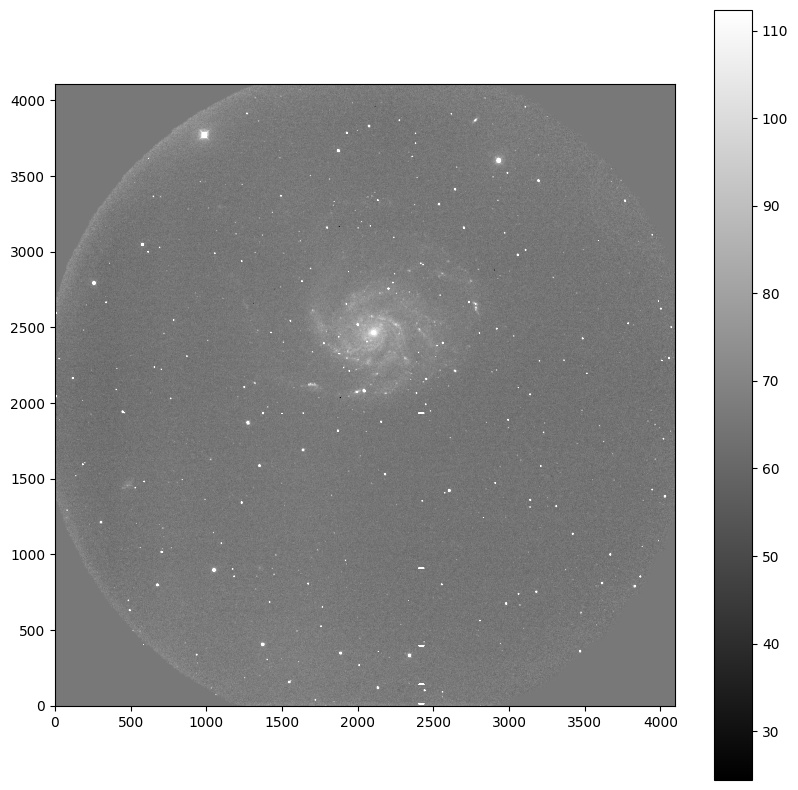

In [3]:
os.chdir('/Users/jigyasachouhan/Documents/Krittika/KSP/Task 2/files_TASK_2')
imageName = '20230605160040-731-RA.wcs.proc.fits'

with fits.open(imageName) as HDUList:
    header = HDUList[0].header
    image = HDUList[0].data

zscale = ZScaleInterval().get_limits(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray', origin='lower', vmin=zscale[0], vmax=zscale[1])
plt.colorbar()
plt.show()

In [4]:
w = WCS(header)
(raImage, decImage) = w.all_pix2world(image.shape[0]/2, image.shape[1]/2, 1)
boxsize = 30 # arcminutes
maxmag = 18

catNum = 'II/349'
print(f'\nQuerying Vizier {catNum} around RA {raImage:.4f}, Dec {decImage:.4f} with a radius of {boxsize} arcmin')

try:
    # You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    v = Vizier(columns=['*'], column_filters={"gmag":f"<{maxmag}", "Nd":">6", "e_gmag":f"<{1.086/3}"}, row_limit=-1)
    Q = v.query_region(SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=str(boxsize)+'m', catalog=catNum, cache=False)
    print(Q[0])
except:
    print('I cannnot reach the Vizier database. Is the internet working?')


Querying Vizier II/349 around RA 210.9163, Dec 54.3055 with a radius of 30 arcmin
   RAJ2000       DEJ2000          objID        ...  yKmag  e_yKmag  yFlags 
     deg           deg                         ...   mag     mag           
------------- ------------- ------------------ ... ------- ------- --------
210.742615990  53.833559350 172602107425380972 ... 14.8609  0.0072 16892216
210.718414070  53.855258900 172622107184277027 ... 14.6260  0.0041   115000
210.729459870  53.862978240 172632107294506278 ... 15.1832  0.0043   115000
210.619208030  53.859197160 172632106192321737 ... 16.7655  0.0099   115000
210.640428410  53.846302080 172612106404566277 ... 17.4766  0.0189   115000
210.554076400  53.858930470 172632105540881436 ... 16.7734  0.0168   115000
210.557995210  53.868460630 172642105580372852 ... 15.4802  0.0043   115000
210.663724090  53.919290610 172702106637313866 ... 16.4559  0.0164   115000
210.663539540  53.892741500 172672106635471999 ... 16.3082  0.0166   115000
     

In [5]:
Q[0].meta['desc'] = Q[0].meta.pop('description')
Q[0].write('/Users/jigyasachouhan/Documents/Krittika/KSP/Task 2/files_TASK_2/ps1Catalog.fits', format='fits', overwrite=True)

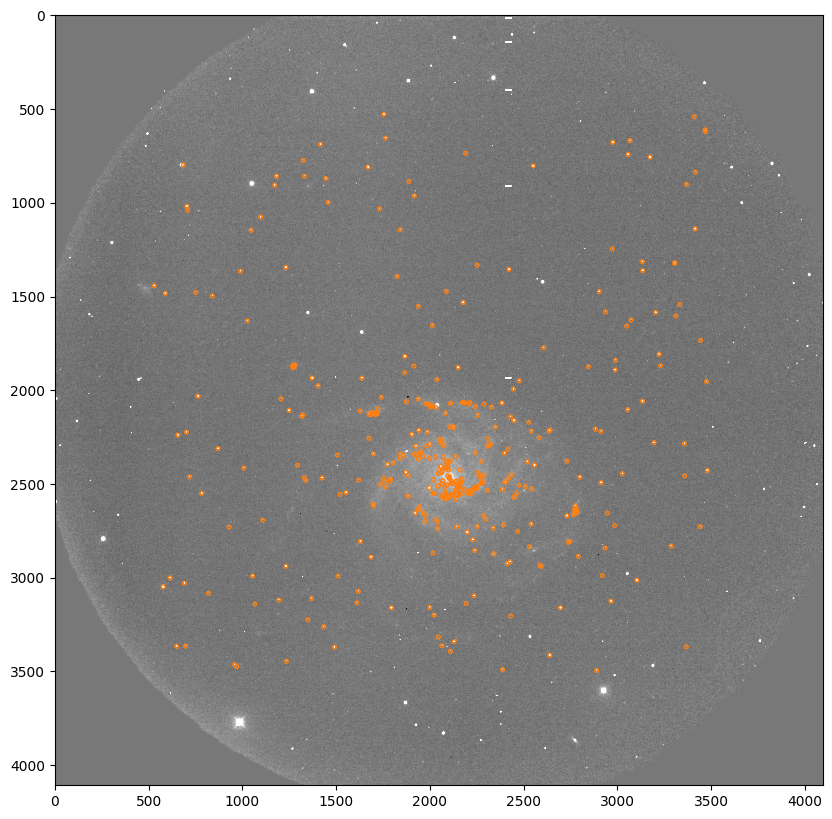

In [6]:
ps1_imCoords = w.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)
good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]
ps1_imCoords = w.all_world2pix(good_cat_stars['RAJ2000'],good_cat_stars['DEJ2000'], 1)

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((ps1_imCoords[0][i], ps1_imCoords[1][i]), radius = 10, edgecolor='C1', facecolor='None') for i in range(len(ps1_imCoords[0]))]
for c in circles:
    ax.add_artist(c)
    
plt.show()

In [7]:
configFile = 'photomCat.sex'
catalogName = imageName + '.cat'
paramName = 'photomCat.param'
try:
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {catalogName} -PARAMETERS_NAME {paramName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230605160040-731-RA.wcs.proc.fits -CATALOG_NAME 20230605160040-731-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2024-07-01 at 12:10:00 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605160040-731-RA.wcs.proc.fits
----- Measuring from: 20230605160040-731-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 65.6003    RMS: 13.0624    / Threshold: 130.624    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100

In [8]:
with fits.open(catalogName) as HDU:
    print(HDU.info())
    sourceTable = Table(HDU[2].data)

print(sourceTable.colnames)
print(sourceTable)

cleanSources = sourceTable[(sourceTable['FLAGS']==0) & (sourceTable['FWHM_WORLD'] < 2) & (sourceTable['XWIN_IMAGE']<3500) & (sourceTable['XWIN_IMAGE']>500) & (sourceTable['YWIN_IMAGE']<3500) & (sourceTable['YWIN_IMAGE']>500)]

Filename: 20230605160040-731-RA.wcs.proc.fits.cat
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [18880A]   
  2  LDAC_OBJECTS    1 BinTableHDU    106   200R x 25C   [729E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 10E, 10E, 10E, 10E]   
None
['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLUX_APER', 'FLUXERR_APER', 'MAG_APER', 'MAGERR_APER']
         VIGNET          X_IMAGE  ...          MAGERR_APER          
----------------------- --------- ... ------------------------------
14.282227 .. -3.2856216 2417.4866 ... 0.00036388537 .. 0.00036669575
10.010216 .. -2.8222961 1717.9652 ...     0.014

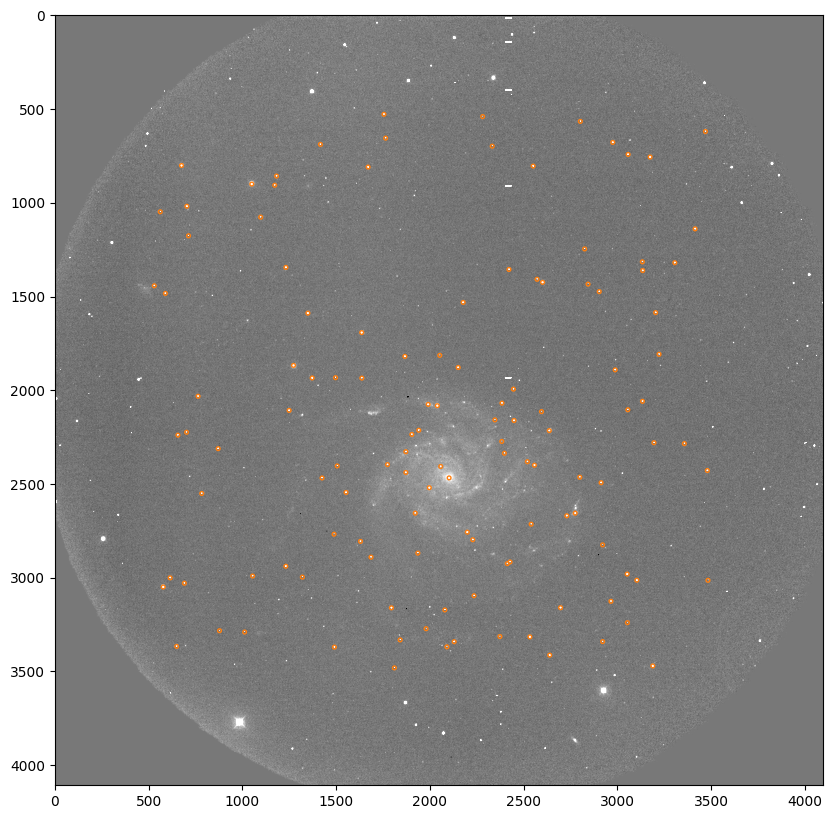

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
plt.imshow(image, cmap='gray', vmin=zscale[0], vmax=zscale[1])
circles = [plt.Circle((source['XWIN_IMAGE'], source['YWIN_IMAGE']), radius = 10, edgecolor='C1', facecolor='None') for source in cleanSources]
for c in circles:
    ax.add_artist(c)
plt.show()

In [10]:
psfConfigFile = 'psfex_conf.psfex'

try:
    command = f'psfex -c {psfConfigFile} {catalogName}'
    print(f'Executing command: {command}')
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run psfex with exit error {err}')

Executing command: psfex -c psfex_conf.psfex 20230605160040-731-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



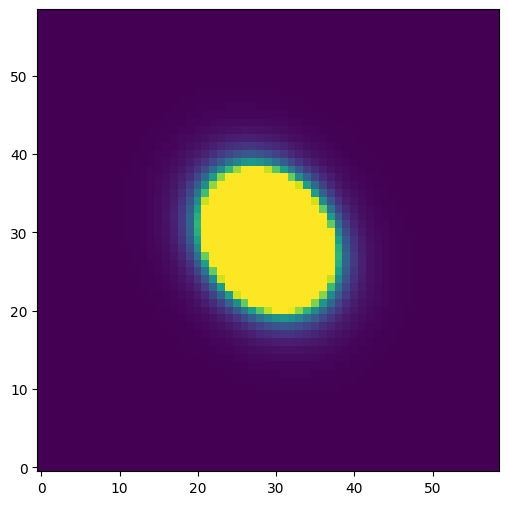

In [11]:
psfModelHDU = fits.open('moffat_' + imageName + '.fits')[0]
psfModelData = psfModelHDU.data
mean, median, std = sigma_clipped_stats(psfModelData)

plt.figure(figsize=(6,6))
plt.imshow(psfModelData, vmin=0, vmax=median+20*std, origin='lower')
plt.show()

In [12]:
psfName = imageName + '.psf'
psfcatalogName = imageName+'.psf.cat'
psfparamName = 'photomPSF.param' # This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
try:
    # We are supplying SExtactor with the PSF model with the PSF_NAME option
    command = f'sex -c {configFile} {imageName} -CATALOG_NAME {psfcatalogName} -PSF_NAME {psfName} -PARAMETERS_NAME {psfparamName}'
    print(f"Executing command: {command}")
    rval = subprocess.run(command.split(), check=True)
except subprocess.CalledProcessError as err:
    print(f'Could not run sextractor with exit error {err}')

Executing command: sex -c photomCat.sex 20230605160040-731-RA.wcs.proc.fits -CATALOG_NAME 20230605160040-731-RA.wcs.proc.fits.psf.cat -PSF_NAME 20230605160040-731-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2024-07-01 at 12:10:03 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230605160040-731-RA.wcs.proc.fits
----- Measuring from: 20230605160040-731-RA.wcs.proc.fits
      "SN2023ixf" / no ext. header / 4096x4108 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 65.6003    RMS: 13.0624    / Threshold: 130.624    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextr

In [13]:
with fits.open(psfcatalogName) as HDU:
    psfsourceTable = Table(HDU[2].data)

print(psfsourceTable.colnames)
print(psfsourceTable)

cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

['VIGNET', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ALPHAWIN_J2000', 'DELTAWIN_J2000', 'FLUX_RADIUS', 'FWHM_WORLD', 'FLUX_AUTO', 'FLUXERR_AUTO', 'SNR_WIN', 'ELONGATION', 'FLUX_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', 'BACKGROUND', 'CLASS_STAR', 'FLAGS_MODEL', 'NITER_MODEL', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_POINTSOURCE', 'FLUXERR_POINTSOURCE', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'FLUXRATIO_POINTSOURCE', 'FLUXRATIOERR_POINTSOURCE']
         VIGNET          X_IMAGE  ... FLUXRATIOERR_POINTSOURCE
----------------------- --------- ... ------------------------
14.282227 .. -3.2856216 2417.4866 ...                      0.0
10.010216 .. -2.8222961 1717.9652 ...                      0.0
 18.039597 .. 17.093391 2556.4927 ...                      0.0
41.908928 .. 13.6970825 2438.3726 ...                      0.0
  -5.853916 .. 16.60582 2130.4023 ...                      0.0
19.543633 .. 0.85396576 2417.4946 ...                      0.0
 -3.929

In [14]:
psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
ps1CatCoords = SkyCoord(ra=good_cat_stars['RAJ2000'], dec=good_cat_stars['DEJ2000'], frame='icrs', unit='degree')
photoDistThresh = 0.6
idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

print(f'Found {len(idx_psfimage)} good cross-matches')

Found 81 good cross-matches


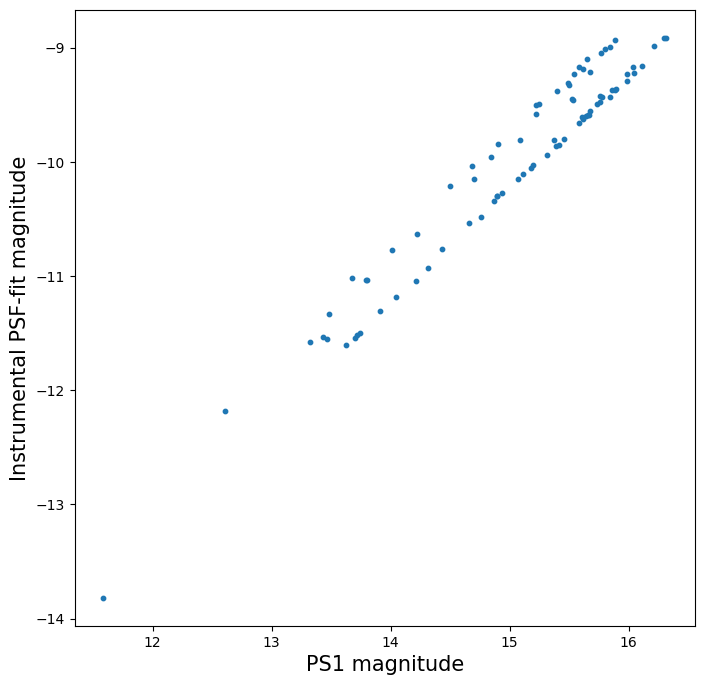

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(good_cat_stars['gmag'][idx_psfps1], cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage], color='C0', s=10)
plt.xlabel('PS1 magnitude', fontsize=15)
plt.ylabel('Instrumental PSF-fit magnitude', fontsize=15)
plt.show()

In [16]:
psfoffsets = ma.array(good_cat_stars['gmag'][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

PSF Mean ZP: 25.07
PSF Median ZP: 25.20
PSF STD ZP: 0.21


In [17]:
ra = 210.910674637
dec = 54.3116510708

sn2023ixf_coords = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idx_sn2023ixf, idx_cleanpsf_sn2023ixf, d2d, d3d = psfsourceCatCoords.search_around_sky(sn2023ixf_coords, photoDistThresh*u.arcsec)
print(f'Found the source at index {idx_cleanpsf_sn2023ixf[0]}')

Found the source at index 49


In [18]:
sn2023ixf_psfinstmag = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAG_POINTSOURCE'][0]
sn2023ixf_psfinstmagerr = cleanPSFSources[idx_cleanpsf_sn2023ixf]['MAGERR_POINTSOURCE'][0]

sn2023ixf_psfmag = zero_psfmed + sn2023ixf_psfinstmag
sn2023ixf_psfmagerr = np.sqrt(sn2023ixf_psfinstmagerr**2 + zero_psfstd**2)

print(f'PSF-fit magnitude of SN2023ixf is {sn2023ixf_psfmag} +/- {sn2023ixf_psfmagerr}')

PSF-fit magnitude of SN2023ixf is 11.28050200958252 +/- 0.21118156044149017
